# Bus Analytics Toolkit for Bus Bunching Mitigation

# Bus Simulator Sandbox
## Yuwen Chang

# I. Data Pipeline
## 1. Vehicle Data
### 1a. Real-time Data Query
### 1b. Historical Sample Data

## 2. Route Data
### 2a. CallDistanceAlongRoute
### 2b. Query from GTFS Data
### 2c. Shapefile

# II. Dashboard
## 1. Time-space Diagram
## 2. Route Topology
## 3. Plain Line
## 4. Basemap
## 5. Analytics

# III. Simulator
## 1. Objects
### 1a. Bus
### 1b. Stop
## 2. Parameters
## 3. Inputs
## 4. Display
## 5. Analytics

![](str.png)

In [23]:
# import packages
from __future__ import print_function, division
from IPython.display import display, clear_output, Image

import os
import sys
import json
import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fiona
import folium
import geopandas as gpd
import mplleaflet as mlf
from shapely.geometry import Point

import time
import calendar
from datetime import datetime

import collections
from collections import defaultdict

import scipy.stats as ss
from fetchbus import flatten, bus_data, plot_tsd
from demo import *

try:
    import urllib2 as urllib
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as io

except ImportError:
    import urllib.request as urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'beta', 'flatten']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# I. Data Pipeline
## 1. Vehicle Data
## 1a. Real-time Data Query

In [4]:
# get MTA API key
try:
    # for local running
    MTAAPI = os.getenv("MTAAPIKEY")
    len(MTAAPI)
except:
    # for CUSP ADRF running only
    from APIs import MTAAPI
    MTAAPI = MTAAPI()

# APIKEY, ROUTE, DURATION

In [5]:
# !python fetchbus.py $MTAAPIKEY "M1" 240
df = bus_data(MTAAPI, "M1", 1)


Time Elapsed: 0.0 min(s)
Bus Line: M1
Number of Active Buses: 14
Error: <class 'KeyError'>
Bus 2 (#MTA NYCT_6771) is at latitude 40.816568 and longitude -73.938784
Bus 3 (#MTA NYCT_6786) is at latitude 40.764524 and longitude -73.972831
Bus 4 (#MTA NYCT_3882) is at latitude 40.760048 and longitude -73.976097
Bus 5 (#MTA NYCT_6770) is at latitude 40.732247 and longitude -73.99015
Bus 6 (#MTA NYCT_3896) is at latitude 40.79924 and longitude -73.945394
Bus 7 (#MTA NYCT_3830) is at latitude 40.762349 and longitude -73.972315
Bus 8 (#MTA NYCT_6768) is at latitude 40.776059 and longitude -73.962315
Bus 9 (#MTA NYCT_6776) is at latitude 40.820909 and longitude -73.935886
Bus 10 (#MTA NYCT_3885) is at latitude 40.739354 and longitude -73.986972
Bus 11 (#MTA NYCT_6748) is at latitude 40.777731 and longitude -73.96319
Bus 12 (#MTA NYCT_3902) is at latitude 40.777897 and longitude -73.963069
Bus 13 (#MTA NYCT_3834) is at latitude 40.720668 and longitude -74.000358
Bus 14 (#MTA NYCT_3893) is at l

KeyboardInterrupt: 

## 1b. Historical Sample Data
# M1-Tue-180410-154415-260.csv

In [24]:
fname = "MTA_data/M1-Tue-180410-154415-260.csv"
df = pd.read_csv(fname)
df = df_process(df, 1)
df = df_addts(df)
df.head()

/Users/Yuwen/Dropbox/BusSimulator/demo.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
/Users/Yuwen/Dropbox/BusSimulator/demo.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])


,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,VehDistAlongRoute,ts
1,1,233.31764,MTA NYCT_OF_B8-Weekday-SDon_E_OF_52620_M7-205,7653.54,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-088000_M7_205,E VILLAGE 8 ST via 5 AV,MTA_403793,1,0.00,...,NaN,M1,2018-04-10 19:44:02,5 AV/W 59 ST,MTA_400512,0,MTA NYCT_6764,1,7653.54,0
2,2,49.23225,MTA NYCT_OF_B8-Weekday-SDon_E_OF_50340_M1-139,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-084200_M1_139,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,6.76,...,layover,M1,2018-04-10 19:44:10,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_6748,1,13723.60,0
3,3,233.78738,MTA NYCT_OF_B8-Weekday-SDon_E_OF_55860_M1-149,1270.21,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-093400_M1_149,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,9.06,...,NaN,M1,2018-04-10 19:43:47,5 AV/W 135 ST,MTA_400094,0,MTA NYCT_6759,1,1261.15,0
4,4,234.06093,MTA NYCT_OF_B8-Weekday-SDon_E_OF_51900_M1-141,9963.37,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-086800_M1_141,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,14.94,...,NaN,M1,2018-04-10 19:43:45,5 AV/W 31 ST,MTA_400325,0,MTA NYCT_6773,1,9948.43,0
6,6,233.75938,MTA NYCT_OF_B8-Weekday-SDon_E_OF_29580_M1-123,4506.30,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-091900_M1_147,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,21.44,...,NaN,M1,2018-04-10 19:43:55,5 AV/EAST 98 ST,MTA_404081,0,MTA NYCT_6778,1,4484.86,0


## 2. Route Data
- METHOD 1: Subset and sort built-in data using CallDistanceAlongRoute in df
- METHOD 2: Query latest GTFS data through online database
- METHOD 3: Use up-to-date shapefile, read as gpd and query

## 2a. CallDistanceAlongRoute
Caveat: only available when there is at least one complete run in the data (can be combined by several buses)

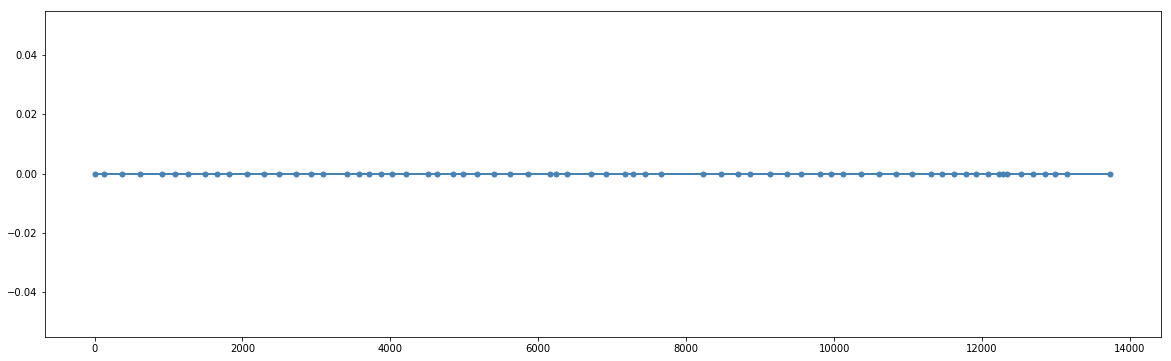

In [8]:
stops_x = df['CallDistanceAlongRoute'].unique()
stops_y = [0] * len(stops_x)

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(stops_x, stops_y, 'o-', color='steelblue', markersize=5)

## 2b. Query from GTFS Data
Caveat: multiple routes and shapes for a bus line

In [25]:
# find the most common route id to query the route shape
df['DatedVehicleJourneyRef'].unique()
df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

'OF_B8-Weekday-SDon-095400_M1_154'

In [26]:
# make query for a given route
# the shape.txt files are pre-uploaded to my Carto space as csv files
route = df['PublishedLineName'].unique()[0]
boro = route[0].lower() # make query from respecttive GTFS shape csv
trip_id = df['DatedVehicleJourneyRef'].value_counts().idxmax()[9:]

q_shape = '''
SELECT *
FROM shapes_{0}
WHERE shape_id = (
  SELECT shape_id
  FROM trips_{0}
  WHERE trip_id = '{1}')
ORDER BY shape_pt_sequence
'''.format(boro, trip_id)

q_stop = '''
query stops shapefile here
'''

In [27]:
r_shape = pd.read_csv(io(queryCartoDB(q_shape)), sep=',')
r_shape['geometry'] = [Point(r_shape.iloc[i,5], r_shape.iloc[i,4]) for i in range(len(r_shape))]
shape_gdf = gpd.GeoDataFrame(r_shape)
shape_gdf.plot(facecolor='r', edgecolor='k', markersize=5, figsize=(10,10))
mlf.display()

## 2c. Shapefile
Caveat: currently, I haven't found a good source that provides official or reliable constant update, but if there is one, this one is probably the easiest way

In [28]:
# specify line and direction query
lineref = 'M1'
direction = 1

# read route shapefile
gdf = gpd.read_file("MTA_shp/bus_routes_nyc_aug2017.shp")
gdf.to_crs(epsg=4326, inplace=True)

# plot route
route_shp = gdf[gdf['route_dir'] == '%s_%s'%(lineref, direction)]
route_shp.plot(color='red', figsize=(10,10))
mlf.display()

# II. Dashboard
## 1. Time-space Diagram
## 2. Route Topology
## 3. Plain Line

KeyboardInterrupt: 

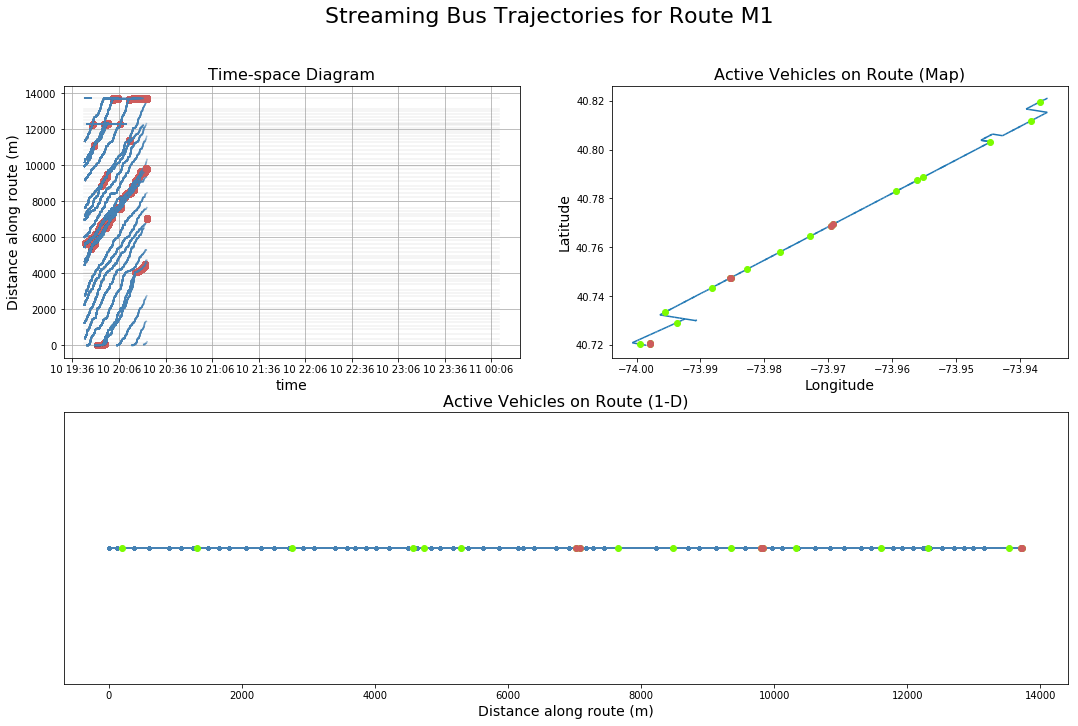

In [29]:
dash_hist(df, route_shp)

## 4. Basemap

In [8]:
fname = "MTA_data/M1-Tue-180410-154415-260.csv"
df = pd.read_csv(fname)
df = df_process(df, 1)
df = df_addts(df)
df2 = df[df['ts'] == 3600] # data of 17 hr

/Users/Yuwen/Dropbox/BusSimulator/demo.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
/Users/Yuwen/Dropbox/BusSimulator/demo.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])


In [9]:
route_pts = list(zip(shape_gdf['shape_pt_lat'], shape_gdf['shape_pt_lon']))
veh_pts = list(zip(df2['Latitude'], df2['Longitude']))

In [10]:
m = folium.Map(
    location=[40.729578, -73.993264],
    zoom_start=7,
    tiles='Stamen Terrain'
)

folium.PolyLine(route_pts).add_to(m)
for v in veh_pts:
    folium.Marker(v).add_to(m)
m

## 5. Analytics (approximate)
### Issues:
- drop duplicates may remove same vehicle if it had several runs during the period
- when is vehicle really at stop?
- do we capture every vehicle that pass by the stop?

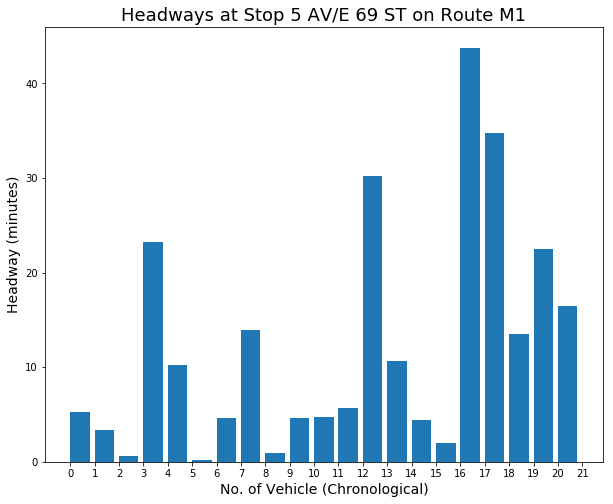

In [13]:
plot_headway(df, "M1", 34)

# III. Simulator

## 2. Parameters

In [30]:
# set parameters
time_coef = 100000 # simulation time is __ times faster than the reality
avg_door_t = 4 # assume opening and closing the door take 4 seconds in total
avg_board_t = 2 # assume each boarding takes 2 sec
avg_alight_t = 1 # assume each alight takes 1 sec

## 3. Inputs

In [31]:
# determine data source
beta = False

if beta:
    # artificial data   ### make this part automatized with given number of stop
    stop_ref = np.array([1, 2, 3, 4, 5, 6, 7])
    stop_pos = np.array([0, 100, 200, 300, 400, 500, 600])
    stop_name = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
    pax_hr_route = 2000
else:
    # historical data
    stop_ref, stop_pos, stop_name = read_data("MTA_data/M1-Tue-180410-154415-260.csv", 1)
    pax_hr_route = 13000

# speed and travel time data are currently artificial
link_vel = 1.5 * np.random.randn(len(stop_pos)) + 6 # make sure the unit is m/sec

# pax distribution
stop_pos_next = np.append(stop_pos, stop_pos[-1])[1:]

pos_mu = stop_pos.mean() # mean stop distance (not midpoint of route)
pos_std = stop_pos.std() # s.d. of stop distances
pax_norm = ss.norm(loc=pos_mu, scale=pos_std)
pax_perc = np.array([pax_norm.cdf(stop_pos_next[i]) - pax_norm.cdf(stop_pos[i]) for i in range(len(stop_pos))]) ### a temporary measure ###

pax_hr_stop = pax_hr_route * pax_perc # total amount passenger per hr at each stop
pax_at_stop = np.zeros(len(stop_pos))

## 1. Objects
## 1a. Bus

In [32]:
# Bus class
class Bus(object):
    
    capacity = 60
    seat = 40
    
    def __init__(self, ref, pos=0):
        self.ref = ref # vehicle reference
        self.pos = pos # vehicle location (1-D)
        self.link = np.sum(self.pos >= stop_pos) - 1 # link index starts from 0  ### unified with the formula in Stop Class
        self.vel = link_vel[self.link] # speed at current link
        self.next_stop = stop_pos[self.link + 1] # position of next stop
        self.dwell_t = 0
        self.pax = 0
        self.clock = 0
        self.operate = True
        self.atstop = False
        
        self.log_pos = [self.pos]
        self.log_vel = [self.vel]
        self.log_pax = [0]
        self.log_dwell = [0]

    def terminal(self):
        print("The bus has reached the terminal")
        self.operate = False
        self.vel = 0
        self.pax = 0
        
    def stop(self):
        print("Bus %s is making a stop at %s (position %i)"%(self.ref, stop_name[self.link + 1], self.next_stop))
        self.atstop = True
        self.pax_to_board = pax_at_stop[self.link + 1] # check how many pax at stop
        self.board_t = self.pax_to_board * avg_board_t
        self.alight_t = 0 * avg_alight_t  #### TO DEVELOP
        self.dwell_t = avg_door_t + self.alight_t + self.board_t # supposed to dwell for this long
        self.clock += 1

#         self.vel = 0
#         self.pos += self.vel
        self.record()

    def move(self):
        pax_at_stop[self.link + 1] = 0 # clear all pax at stop
        self.log_dwell.append(self.dwell_t)
        # move on!
        self.atstop = False
        self.dwell_t = 0
        self.clock = 0
        self.link += 1
        self.pax = 0 # update pax onboard ###################
        self.record()
        self.vel = link_vel[self.link] # new link speed
        self.next_stop = stop_pos[self.link + 1] # new next stop

    def record(self):
        self.log_pos.append(self.pos)
        self.log_pax.append(self.pax)
        
    def proceed(self):
        if self.operate:
            if self.pos + self.vel >= stop_pos[-1]:
                self.terminal()
            elif self.pos + self.vel >= self.next_stop:  ### this judgement restricts from recording vel as 0 at stop, change to sth else
                self.stop()
                if self.clock >= self.dwell_t:
                    self.move()
            else:
                print("Current position of bus %s: %i"%(self.ref, self.pos))
                self.pos += self.vel
                self.record()
        else:
            print("Bus %s is not operating."%(self.ref))

## 1b. Stop

In [33]:
class Stop(object):
    
    pos_mu = stop_pos.mean()
    pos_std = stop_pos.std()
    pos_len = np.diff(stop_pos) # segment length starting from link 0

    def __init__(self, i):
        self.ref = stop_ref[i] # stop reference
        self.pos = stop_pos[i] # stop location (1-D)
        self.name = stop_name[i] # stop name
        self.link = i # the link (index from 0) that the stop belongs to
#         self.link = list(stop_ref).index(self.ref) # link index starts from 0
        self.pax = 0
        self.first = self.pos == stop_pos[0]
        self.last = self.pos == stop_pos[-1]
        self.clock = 0
        self.log_pax = [0]
        self.log_wait_t = [0]
#        self.log_msg = []
#        self.log_spacing

    def new_pax(self): # randomly generate new pax each second
        # future function, also consider bus frequency to determine arrival distribution
        # frequent services tend to have uniform arrivals
        return int(np.random.poisson(lam=(pax_hr_stop[self.link]/3600), size=1))  # lambda = (avg pax/hr) / sec
    
    def update(self):
        self.clock += 1
        self.pax += self.new_pax()
        pax_at_stop[self.link] = self.pax # update global listing of pax at each stop
        return self.pax

    def record(self):
        self.log_pax.append(self.pax)

    def proceed(self):
        if pax_at_stop[self.link] < self.pax: # if pax are cleared by a bus
            self.pax = pax_at_stop[self.link] # reverse update
            self.log_wait_t.append(self.clock)
            self.clock = 0

        self.update()
        self.record()

## 4. Display

In [34]:
# generate stops
# generate buses

if beta:
    stop1 = Stop(0)
    stop2 = Stop(1)
    stop3 = Stop(2)
    stop4 = Stop(3)
    stop5 = Stop(4)
    stop6 = Stop(5)
    stop7 = Stop(6)
    stops = [stop1, stop2, stop3, stop4,
             stop5, stop6, stop7]
    
    bus1 = Bus('7609', 0)
    bus2 = Bus('7828', 250)
    bus3 = Bus('7964', 450)
    buses = [bus1, bus2, bus3]
    
else:
    d={}
    for i in range(len(stop_pos)):
        d["stop%s"%(i)] = Stop(i)
    
    bus1 = Bus('7609', 0)
    bus2 = Bus('7828', 1200)
    bus3 = Bus('7964', 2900)
    bus4 = Bus('9829', 3500)
    bus5 = Bus('7361', 4050)
    bus6 = Bus('9999', 5600)
    bus7 = Bus('3283', 6100)
    bus8 = Bus('1281', 6900)
    bus9 = Bus('2345', 7800)
    bus10 = Bus('9811', 9500)
    
    buses = [bus1, bus2, bus3, bus4, bus5,
             bus6, bus7, bus8, bus9, bus10]

KeyboardInterrupt: 

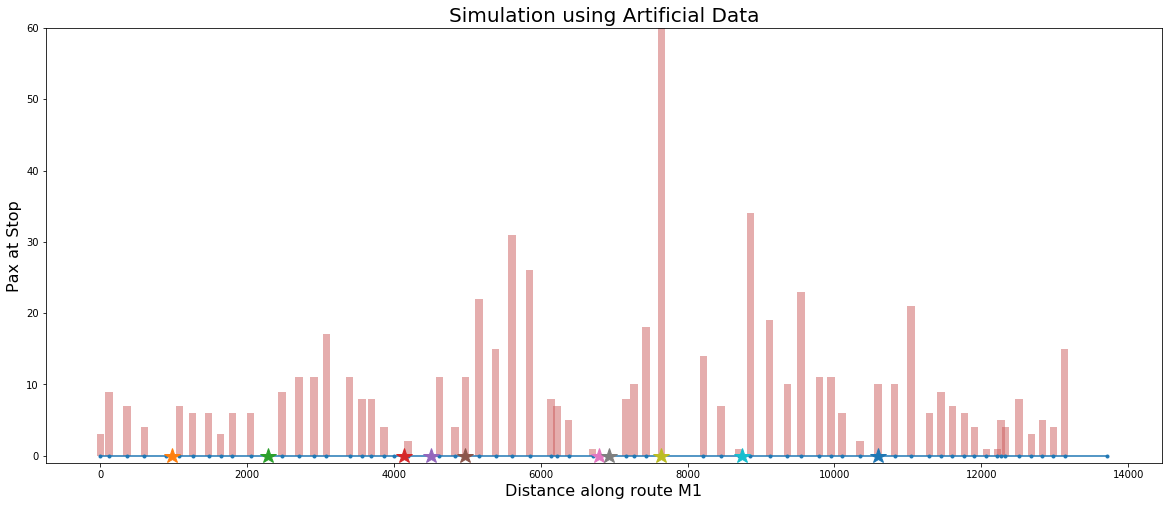

In [35]:
# simulate with historical data
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

### FLATTEN THE CODE HERE!!! ###
ax.plot(stop_pos, np.zeros(len(stop_pos)), '.-')

veh1, = ax.plot(bus1.pos, 0, '*', markersize=16)
veh2, = ax.plot(bus2.pos, 0, '*', markersize=16)
veh3, = ax.plot(bus3.pos, 0, '*', markersize=16)
veh4, = ax.plot(bus4.pos, 0, '*', markersize=16)
veh5, = ax.plot(bus5.pos, 0, '*', markersize=16)
veh6, = ax.plot(bus6.pos, 0, '*', markersize=16)
veh7, = ax.plot(bus7.pos, 0, '*', markersize=16)
veh8, = ax.plot(bus8.pos, 0, '*', markersize=16)
veh9, = ax.plot(bus9.pos, 0, '*', markersize=16)
veh10, = ax.plot(bus10.pos, 0, '*', markersize=16)


# for s in range(len(stop_pos)):
#     ax.plot([stop_pos[s], stop_pos[s]], [0, pax_at_stop[s]], '-', color='indianred')

pax_bar = plt.bar(stop_pos, pax_at_stop, width=100, align='center', color='indianred', alpha=0.5)

#ax.set_yticks([])
ax.set_title('Simulation using Artificial Data', fontsize=20)
ax.set_xlabel('Distance along route M1', fontsize=16)
ax.set_ylabel('Pax at Stop', fontsize=16)
ax.set_ylim(-1, 60)

clock = 0

while bus1.operate:
#     [s.proceed() for s in stops]
    [s.proceed() for s in d.values()]
    [b.proceed() for b in buses]

    veh1.set_xdata(bus1.pos)
    veh2.set_xdata(bus2.pos)
    veh3.set_xdata(bus3.pos)
    veh4.set_xdata(bus4.pos)
    veh5.set_xdata(bus5.pos)
    veh6.set_xdata(bus6.pos)
    veh7.set_xdata(bus7.pos)
    veh8.set_xdata(bus8.pos)
    veh9.set_xdata(bus9.pos)
    veh10.set_xdata(bus10.pos)

    for px, h in zip(pax_bar, pax_at_stop):
        px.set_height(h)

#     pax.set_data(stop_pos, pax_at_stop)
#     for s in range(len(stop_pos)):
#         ax.plot([stop_pos[s], stop_pos[s]], [0, pax_at_stop[s]], '-', color='indianred')
        
    clear_output(wait=True)
    display(fig)
    clock += 1
    print("Time elapsed: %i seconds"%(clock))
    print("Pax at each stop: ", pax_at_stop)
    time.sleep(1/1000) # set a global time equivalent parameter

## 5. Analytics

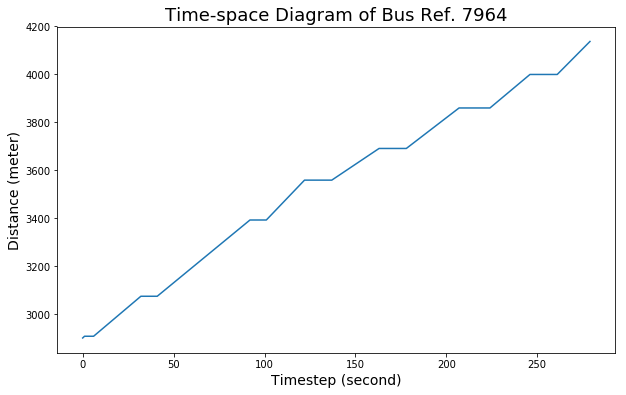

In [36]:
bus_tsd(bus3)

In [43]:
d['stop19'].log_wait_t

[0, 92, 126]

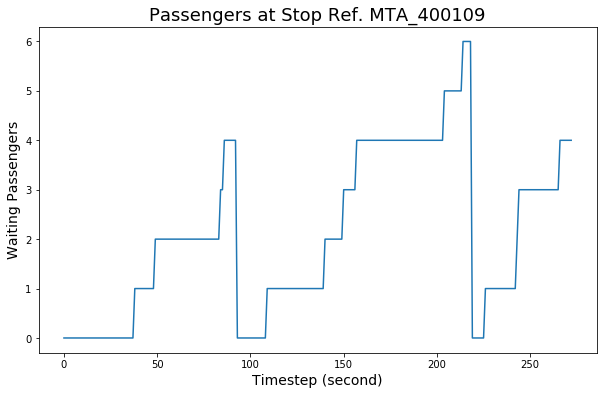

In [42]:
stop_pax(d['stop19'])

In [ ]:
# trace log

## IV. Platform and Package Deployment
on web
1. Control panel
2. Real-time info on Google basemap
3. Real-time info on straightened route topology
    - 3a. BB indicator
4. Dynamic time-space diagram

# End

- 3/11 4
- 3/12 1.5
- 3/16 1
- 3/17 2
- 3/18 2
- 3/20 1.5
- 3/23 2
- 4/3 3
- 4/5 0.5
- 4/6 1.5
- 4/9 1.5
- 4/21 9
- 4/22 9
- 4/23 1
- 4/24 1.5
- 4/25 1.5
- 4/26 5.5
- 4/27 0.5

In [64]:
def realtime(apikey, route, df):
    """
    bus_data function adapted for in-notebook real-time monitoring use
    """
    url = "http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=%s&VehicleMonitoringDetailLevel=calls&LineRef=%s"%(apikey, route)
    
    # fetch data through MTA API
    response = urllib.urlopen(url)
    data = response.read().decode("utf-8")
    data = json.loads(data)

    # check if bus route exists
    try:
        data2 = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['VehicleActivity']
    # print error if bus route not found
    except:
        error = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['ErrorCondition']
        print(error['Description'])

    # print info of the current query request
#     print("Bus Line: " + route)
#     print("Number of Active Buses: " + str(len(data2)))

    # parse the data of each active vehicle
    for i, v in enumerate(data2):
        #if 'OnwardCall' in v['MonitoredVehicleJourney']['OnwardCalls']:
        try:
            # map variables
            dict1 = flatten(v['MonitoredVehicleJourney'])
            dict1['RecordedAtTime'] = v['RecordedAtTime']
            #dict1['SituationSimpleRef'] = dict1['SituationRef'][0]['SituationSimpleRef']
            dict1.pop('SituationRef')
            dict1.pop('OnwardCall')

            # print info of the vehicle
#             print("Bus %s (#%s) is at latitude %s and longitude %s"%(i+1, dict1['VehicleRef'], dict1['Latitude'], dict1['Longitude']))

            # write data to dictionary
            df_new = pd.DataFrame(dict1, index=[i])
            df = pd.concat([df, df_new])

        except Exception as e:
            print("Error: %s"%(e))
            pass
            
    df.to_csv("realtime.csv")
    return df, df_new

In [65]:
def df_update(apikey, route, direction):
    """ Append new data to existing csv file and return both all and new dfs"""
    try:
        df = pd.read_csv("realtime.csv")
    except:
        print("realtime.csv not found, creating new empty df")
        df = pd.DataFrame()
    df, df_new = realtime(apikey, route, df)
    
    # process variables for plotting
    df = df_process(df, direction)
    df_new = df_process(df_new, direction)
    
    return df, df_new

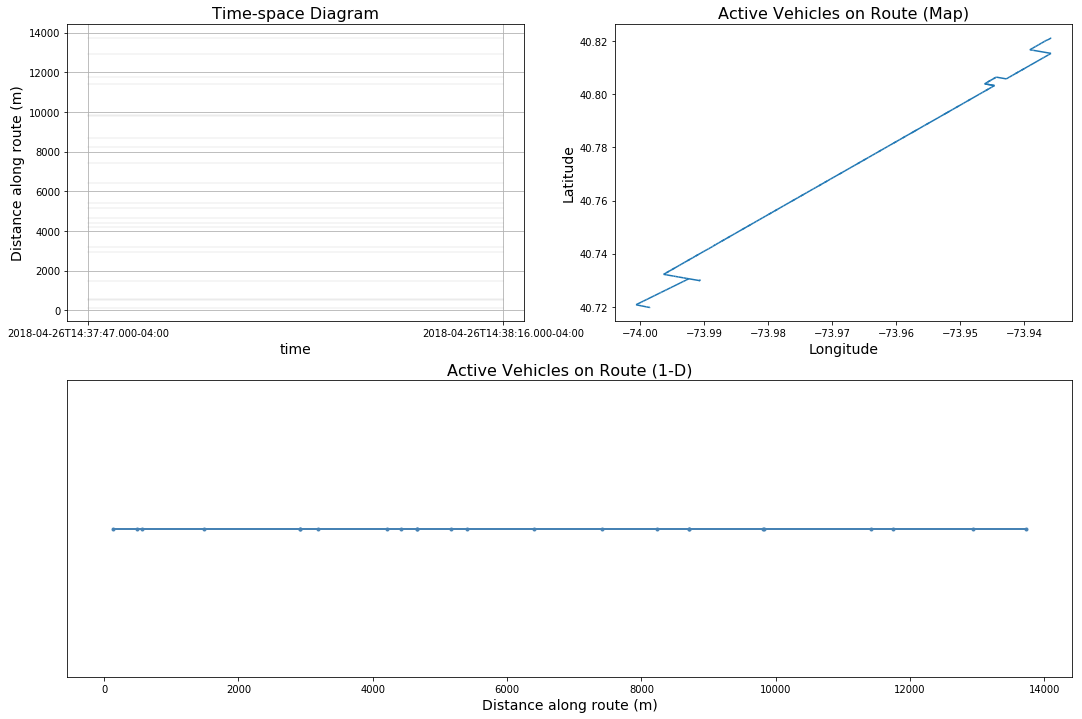

Seconds elapsed: 120


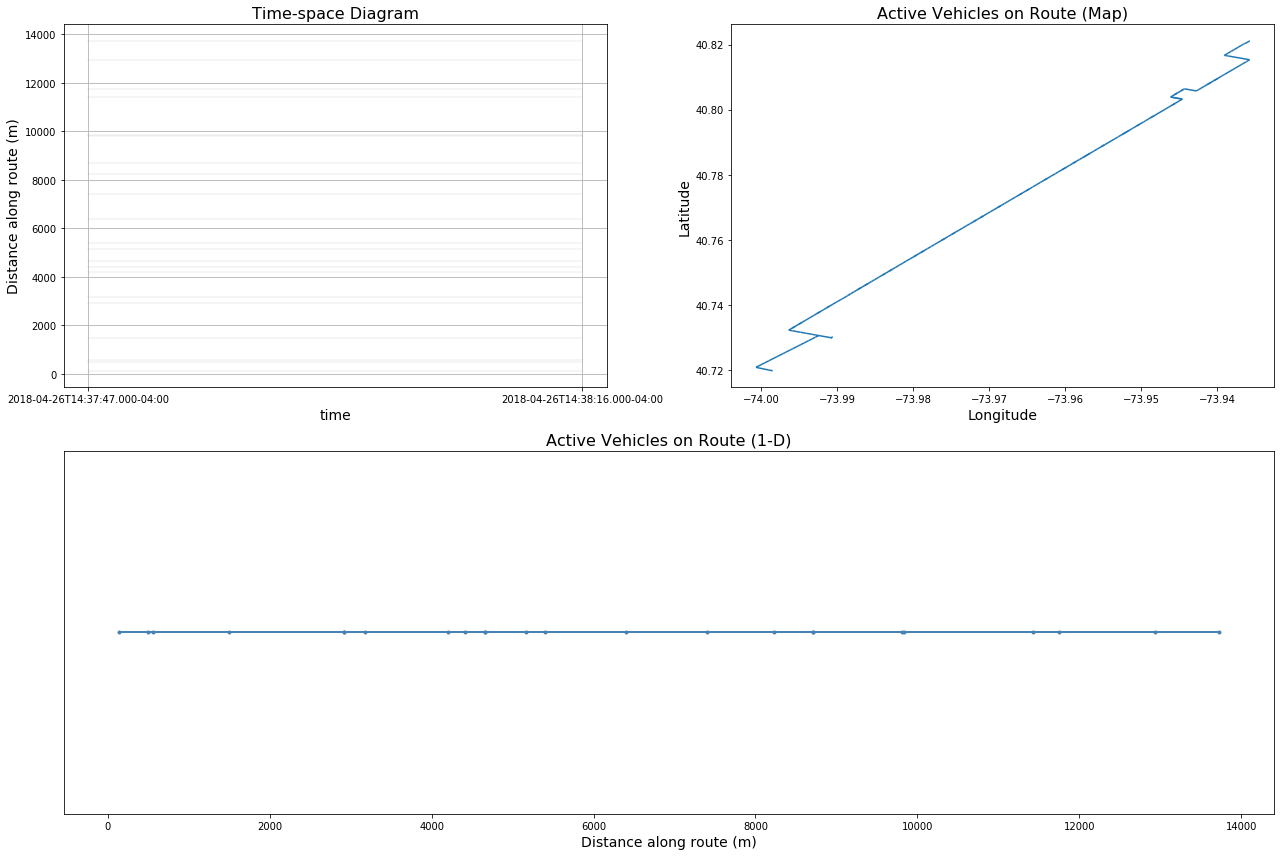

In [73]:
# specify line and direction query
lineref = 'M1'
direction = 1

df = pd.DataFrame()
df, df_new = realtime(MTAAPI, lineref, df)
route_shp = gdf[gdf['route_dir'] == '%s_%s'%(lineref, direction)]

clock = 0

# plot figure
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

# plot CallDistanceAlongRoute (bus stops)
[ax1.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
p1, = ax1.plot([], [], '-', color='steelblue')

ax1.grid()
ax1.set_xlabel("time", fontsize=14)
ax1.set_ylabel("Distance along route (m)", fontsize=14)
ax1.set_title("Time-space Diagram", fontsize=16)

# plot route shape on map (2-D)
route_shp.plot(ax=ax2)
p7, = ax2.plot([], [], 'o', color='lawngreen')
p2, = ax2.plot([], [], 'o', color='indianred')

ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_xlabel("Longitude", fontsize=14)
ax2.set_title("Active Vehicles on Route (Map)", fontsize=16)

# plot dynamic route line (1-D)
ax3.plot(df['CallDistanceAlongRoute'], [0]*len(df), '.-', color='steelblue')
p3, = ax3.plot([], [], 'o', color='lawngreen')
p4, = ax3.plot([], [], 'o', color='indianred')

ax3.set_yticks([])
ax3.set_xlabel("Distance along route (m)", fontsize=14)
ax3.set_title("Active Vehicles on Route (1-D)", fontsize=16)

# update
while clock <= 120:
    df1, df3 = df_update(MTAAPI, lineref, direction)
    
    # mark vehicles that are bunching
    ##### APPEND THIS TRY EXCEPT BACK TO HISTORICAL RUN #####
    ##### OTHERWISE ERROR WHEN THERE IS NO BUNCHING #####
    try:
        df3.sort_values(['VehDistAlongRoute'], inplace=True)
        spacing = np.diff(df3['VehDistAlongRoute'])
        bunch = spacing < 100 # set threshold (meters) to be identified as BB
        bunch_a = np.array([False] + list(bunch))
        bunch_b = np.array(list(bunch) + [False])
        bunch = bunch_a + bunch_b
        bb_df = df3[bunch]
    except:
        pass
    
#     # plot TSD for each vehicle
#     for i, v in enumerate(df1['VehicleRef'].unique()):
#         # subset data for single vehicle
#         veh_df = df1[df1['VehicleRef'] == v]
#         ax1.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], '-', color='steelblue', alpha=0.5)
#         try:
#             ax1.plot(bb_df['RecordedAtTime'], bb_df['VehDistAlongRoute'], 'o', color='indianred', alpha=0.5)
#         except:
#             pass
#         #ax1.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))

    p7.set_data(df3['Longitude'], df3['Latitude'])
    p3.set_data(df3['VehDistAlongRoute'], [0]*len(df3))
    
    try:
        p2.set_data(bb_df['Longitude'], bb_df['Latitude'])
        p4.set_data(bb_df['VehDistAlongRoute'], [0]*len(bb_df))
    except:
        pass
    
    clear_output(wait=True)
    display(fig)
    print("Seconds elapsed: %s"%(clock))
    clock += 30
    time.sleep(30)
    
plt.tight_layout()
plt.show()

NameError: name 'stops' is not defined

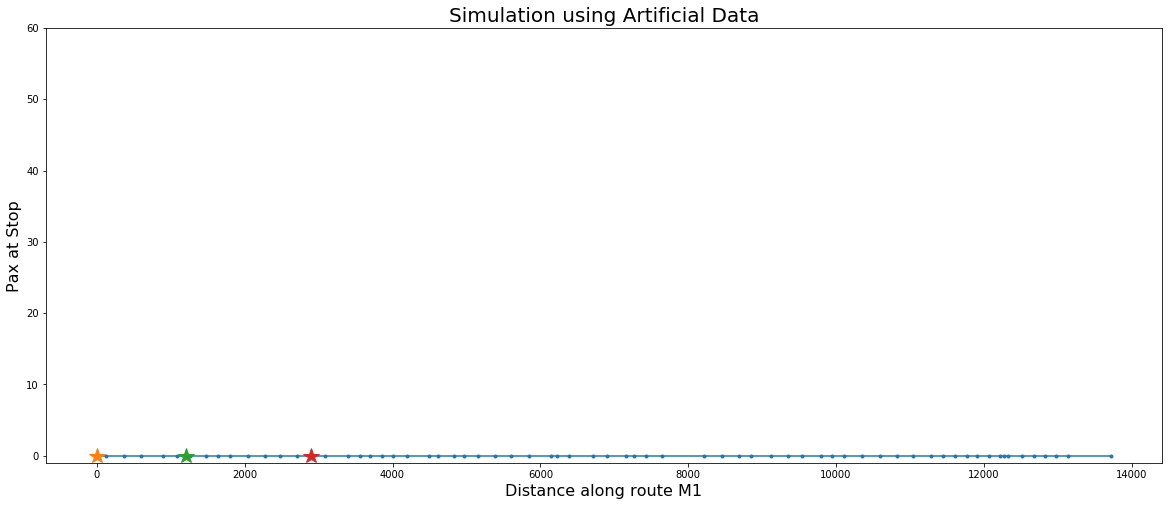

In [32]:
# simulate with artificial data
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

### FLATTEN THE CODE HERE!!! ###
ax.plot(stop_pos, np.zeros(len(stop_pos)), '.-')

veh1, = ax.plot(bus1.pos, 0, '*', markersize=16)
veh2, = ax.plot(bus2.pos, 0, '*', markersize=16)
veh3, = ax.plot(bus3.pos, 0, '*', markersize=16)

pax_bar = plt.bar(stop_pos, pax_at_stop, width=10, align='center', color='indianred', alpha=0.5)

ax.set_title('Simulation using Artificial Data', fontsize=20)
ax.set_xlabel('Distance along route M1', fontsize=16)
ax.set_ylabel('Pax at Stop', fontsize=16)
ax.set_ylim(-1, 60)

clock = 0

while bus1.operate:
    [s.proceed() for s in stops]
#    [s.proceed() for s in d.values()]
    [b.proceed() for b in buses]

    veh1.set_xdata(bus1.pos)
    veh2.set_xdata(bus2.pos)
    veh3.set_xdata(bus3.pos)

    for px, h in zip(pax_bar, pax_at_stop):
        px.set_height(h)

#     pax.set_data(stop_pos, pax_at_stop)
#     for s in range(len(stop_pos)):
#         ax.plot([stop_pos[s], stop_pos[s]], [0, pax_at_stop[s]], '-', color='indianred')
        
    clear_output(wait=True)
    display(fig)
    clock += 1
    print("Time elapsed: %i seconds"%(clock))
    print("Pax at each stop: ", pax_at_stop)
    time.sleep(1/100) # set a global time equivalent parameter

In [16]:
# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from collections import Counter

# from geopy import Nominatim
# from geopy.distance import vincenty
# from shapely.geometry import Point

In [45]:
import gmaps
gmaps.configure(api_key=os.getenv("GOOGLEAPIKEY"))

df_gmap = df[df['ts'] == 0]
location = list(zip(df_gmap['Latitude'], df_gmap['Longitude']))

fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(location))
fig

In [46]:
# calculate stop distances
dist = []
lats = list(B54_merge['stop_lat'])
lons = list(B54_merge['stop_lon'])
for i in arange(len(B54_stops)):
    if i < len(B54_stops) - 1:
        p1 = lats[i], lons[i]
        p2 = lats[i+1], lons[i+1]
        di = vincenty(p1, p2).meters
        dist.append(di)
dist

[164.10592592573394,
 524.6821220855292,
 183.2864635647531,
 166.04481363027242,
 168.16662072005468,
 249.32389728515443,
 280.8678932398275,
 65.1613773786362,
 162.277246106055,
 160.8227222138864,
 156.99423276306914,
 177.8182272706027,
 262.3958689692586,
 186.7201549309188,
 134.44950499065496,
 113.44836241741916,
 271.7303956584878,
 243.00538513176005,
 292.5054493596941,
 190.84614888127206,
 295.74318979161654,
 180.16350288585392,
 297.9947729558094,
 205.45446314960742,
 168.5189134674809,
 151.1404164049675,
 170.5531370778554,
 218.34221496184352,
 226.21779839123397,
 226.0960471262775,
 374.39793393469455,
 130.71672370770722]

In [51]:
# calculate stop distances along the route (cumulative distance)
di = 0
cum_dist = [0]
for d in dist[:-1]:
    di += d
    cum_dist.append(di)
cum_dist = np.array(cum_dist)
cum_dist

array([   0.        ,  164.10592593,  688.78804801,  872.07451158,
       1038.11932521, 1206.28594593, 1455.60984321, 1736.47773645,
       1801.63911383, 1963.91635994, 2124.73908215, 2281.73331491,
       2459.55154218, 2721.94741115, 2908.66756608, 3043.11707107,
       3156.56543349, 3428.29582915, 3671.30121428, 3963.80666364,
       4154.65281252, 4450.39600231, 4630.5595052 , 4928.55427816,
       5134.00874131, 5302.52765477, 5453.66807118, 5624.22120826,
       5842.56342322, 6068.78122161, 6294.87726874, 6669.27520267])

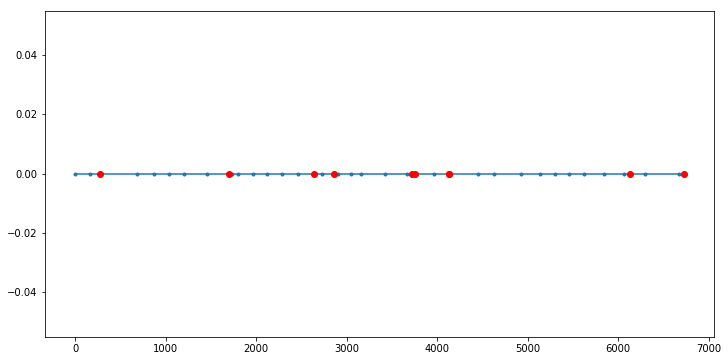

In [63]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(cum_dist, [0]*len(cum_dist), '.-')
ax.plot(df['VehDistAlongRoute'], [0]*len(df), 'ro')
plt.show()

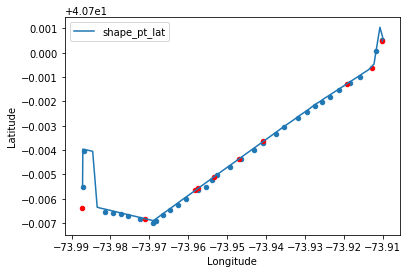

In [64]:
# plot route
ax = temp_shp.plot('shape_pt_lon', 'shape_pt_lat')

# plot stops
B54_stops.plot.scatter('stop_lon', 'stop_lat', ax=ax)

# plot active buses
df.plot.scatter('Longitude', 'Latitude', color='red', ax=ax)